In [58]:
from AnalyzeMot import AnalyzeMOT
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
sys.path.append('../')
import mp1_config

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [59]:
# Lambda to split and retrieve power
split = lambda x : int(x.split(' ')[-1])

path_to_detuning = "./Data/Growth vs cooling power/"
# Sort based on split lambda function (lowest number first)
folders = sorted(os.listdir(path_to_detuning), key=split)

path_to_folders = [os.path.join(path_to_detuning, folder) for folder in folders]

powers = np.array([split(folder) for folder in folders])

print(path_to_folders)
print(len(path_to_folders))
print(powers)

['./Data/Growth vs cooling power/aom 70', './Data/Growth vs cooling power/aom 72', './Data/Growth vs cooling power/aom 74', './Data/Growth vs cooling power/aom 76', './Data/Growth vs cooling power/aom 78', './Data/Growth vs cooling power/aom 80', './Data/Growth vs cooling power/aom 82', './Data/Growth vs cooling power/aom 84', './Data/Growth vs cooling power/aom 86', './Data/Growth vs cooling power/aom 88', './Data/Growth vs cooling power/aom 90', './Data/Growth vs cooling power/aom 92', './Data/Growth vs cooling power/aom 94', './Data/Growth vs cooling power/aom 96', './Data/Growth vs cooling power/aom 98', './Data/Growth vs cooling power/aom 100']
16
[ 70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100]


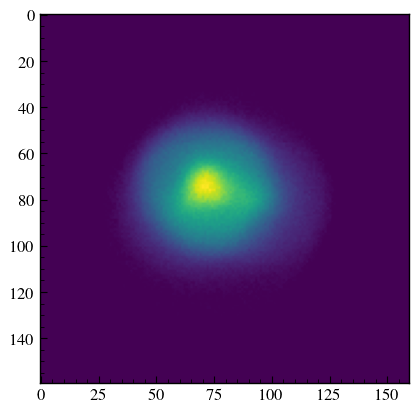

In [61]:
image_size = 80
x_offset = -70
y_offset = -60

analyzer = AnalyzeMOT(path=path_to_folders[-1], image_size=image_size, x_offset=x_offset, y_offset=y_offset)

test_image = analyzer.get_image_matrix(analyzer.files[-1], apply_zoom=True)

plt.imshow(test_image)

In [62]:
def exponential(t, *ps) : 
    A, tau, t0, D = ps[0], ps[1], ps[2], ps[3]
    return A*(1-np.exp(-(t-t0)/tau)) + D

def fit_exponential(time, signal, start_index) : 
    time_to_fit = time[start_index:]
    signal_to_fit = signal[start_index:]

    A0 = max(signal_to_fit) - min(signal_to_fit)
    tau0 = (time_to_fit.max() - time_to_fit.min())/3
    t0 = time_to_fit[0]
    D0 = min(signal_to_fit)

    # Bounds: A, tau > 0; t0 in domain; D unbounded
    lower_bounds = [0, 1e-6, time_to_fit[0], -np.inf]
    upper_bounds = [np.inf, np.inf, time_to_fit[-1], np.inf]

    popt, pcov = curve_fit(exponential, xdata=time_to_fit, ydata=signal_to_fit, p0=[A0, tau0, t0, D0], sigma=np.sqrt(signal_to_fit), bounds=(lower_bounds, upper_bounds))

    tlin = np.linspace(t0, max(time), 1000)
    yfit = exponential(tlin, *popt)

    return (popt, pcov, tlin, yfit)

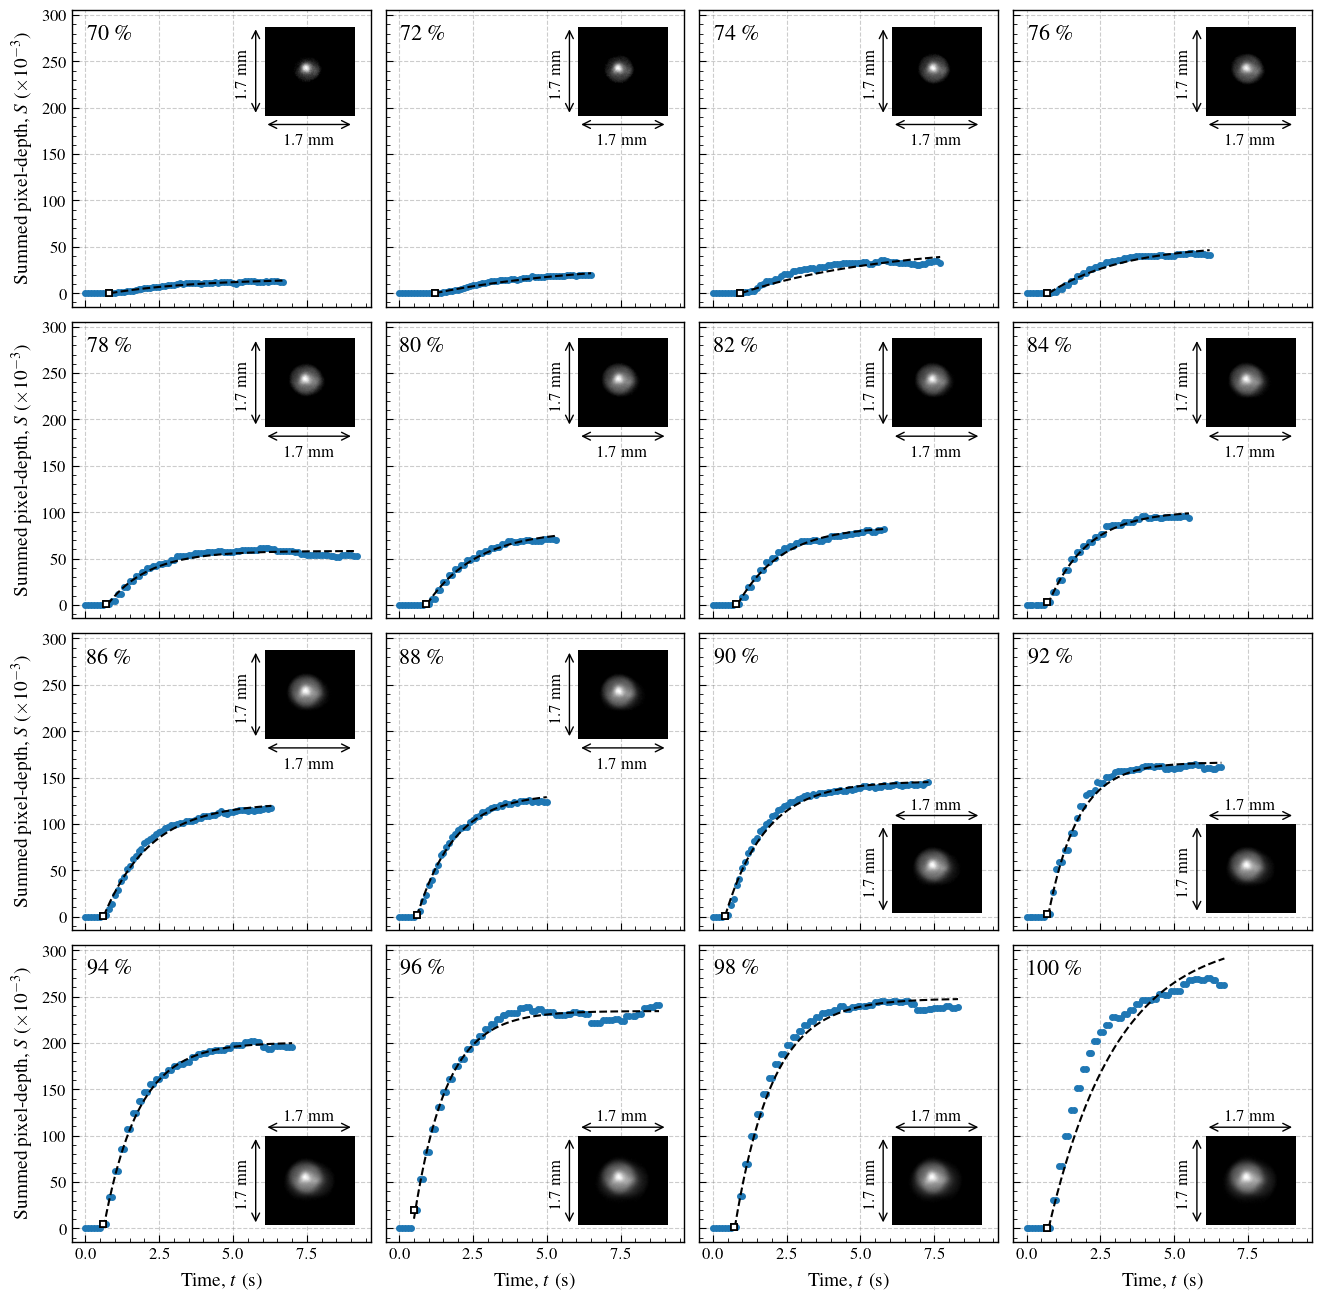

In [63]:
rows, cols = 4,4
fig, axs = plt.subplots(rows, cols, figsize=(4*cols, 4*rows), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.05, hspace=0.05)

axs_flat = axs.flatten()

taus = []
tau_sigs = []

conv = np.around( (analyzer.image_size*2)/1024*11.0, 1)

for i, path in enumerate(path_to_folders) : 
    analyzer.path = path
    
    dts = analyzer.process_filenames(method=analyzer.parse_time_stamp, relative_time=True)
    summed_depths = analyzer.get_summed_bit_depths(threshold=0, normed=False, background_image=None, apply_zoom=True)

    summed_depths = summed_depths * 1e-3

    axs_flat[i].set_title(rf'{powers[i]} $\%$', pad=-20, loc='left', transform=axs_flat[i].transAxes, x=0.05, y=0.9, fontsize=16)

    axs_flat[i].plot(dts, summed_depths, 'o', markersize=4)

    axs_flat[i].grid(alpha=0.4)

    mask = np.where(summed_depths > 0.0)
    start0 = mask[0][0]

    axs_flat[i].plot(dts[start0], summed_depths[start0], marker='s', markeredgecolor='k', markerfacecolor='white', markeredgewidth=1.25, markersize=5)

    popt, pcov, tlin, yfit = fit_exponential(dts, summed_depths, start_index=start0)

    fit_mask = yfit > 0
    axs_flat[i].plot(tlin[fit_mask], yfit[fit_mask], 'k--')

    axs_flat[i].plot(dts[start0], summed_depths[start0], marker='s', markeredgecolor='k', markerfacecolor='white', markeredgewidth=1.25, markersize=5)

    taus.append(popt[1])
    tau_sigs.append(np.sqrt(np.diag(pcov)[1]))
    
    # --- inset image ---
    img = analyzer.get_image_matrix(analyzer.files[-1], apply_zoom=True)
    
    if i < 10 : 
        loc = 'upper right'
        v_arrow_y = -0.1
        text_y = -0.2
    else : 
        loc = 'lower right'
        v_arrow_y = 1.1
        text_y = 1.30
    # place an inset in the corner
    axins = inset_axes(axs_flat[i],
                       width="30%",    # 25% of parent width
                       height="30%",   # 25% of parent height
                       loc=loc,
                       borderpad=1.0)
    axins.imshow(img, cmap='gray')

    # arrows for length scale
    ax = axins
    ax.annotate('', xy=(0, v_arrow_y), xycoords='axes fraction', xytext=(1, v_arrow_y), 
                arrowprops=dict(arrowstyle="<->", color='k', linewidth=1.0))
    ax.text(0.5, text_y, "{} mm".format(conv), fontsize=12,
    ha='center', va='top', transform=ax.transAxes)

    ax.annotate('', xy=(-0.1, 0), xycoords='axes fraction', xytext=(-0.1, 1), 
                arrowprops=dict(arrowstyle="<->", color='k', linewidth=1.0))
    ax.text(-0.25, 0.75, "{} mm".format(conv), rotation=90, fontsize=12,
    ha='center', va='top', transform=ax.transAxes)

    axins.axis('off')
    
for ax in axs[-1] : ax.set_xlabel("Time, $t$ (s)")
for ax in axs[:,0] : ax.set_ylabel("Summed pixel-depth, $S$ ($\\times 10^{-3}$)")

fig.savefig("./Figures/time_vs_signal_at_cooling_power.png", format='png', bbox_inches='tight', dpi=400)

<>:5: SyntaxWarning: invalid escape sequence '\%'
<>:5: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_8505/3792050454.py:5: SyntaxWarning: invalid escape sequence '\%'
  ax.set_xlabel("Laser power ($\%$)")


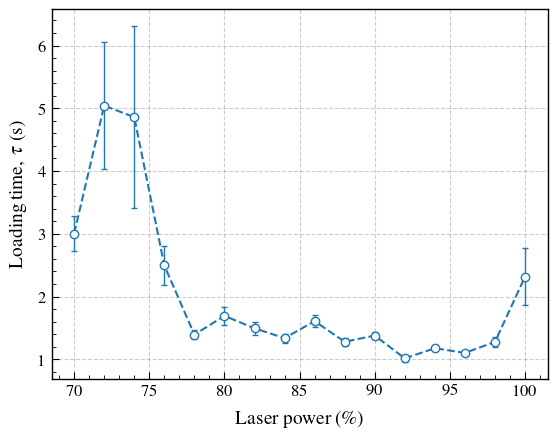

In [64]:
fig, ax = plt.subplots()

ax.errorbar(powers, taus, fmt='o', linestyle='--', yerr=tau_sigs, markerfacecolor='w', markeredgecolor='tab:blue', elinewidth=1.0, capsize=2.0)

ax.set_xlabel("Laser power ($\%$)")
ax.set_ylabel("Loading time, $\\tau$ (s)")
ax.grid(alpha=0.4)

fig.savefig("./Figures/cooling_power_vs_loading_time.png", format='png', bbox_inches='tight', dpi=400)